# Saving fit results using BurstIO class

In [1]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_me
from burstfit.utils.functions import pulse_fn_vec, sgram_fn_vec, gauss_norm
from burstfit.io import BurstIO
import logging

In [2]:
logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=logging_format,
)

Let's quickly do a fitting using BurstData and BurstFit classes. 

## Burst Fitting

Get data and preprocess

In [3]:
fil_file = '../tests/data/tcand_2_dm_565.30000_snr_11.92560.fil'

In [4]:
bd = BurstData(
    fp=fil_file,
    dm=565.3,
    tcand=2,
    width=64,
    snr=11.9,
    min_samp=256,
)

In [5]:
bd.prepare_data(mask_chans=[(53, 64)])

2021-03-18 19:54:15,367 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2021-03-18 19:54:15,415 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.2s.
2021-03-18 19:54:15,416 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2021-03-18 19:54:15,527 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (128.00148285380777, 19.999437514831243)


Using <class 'str'>:
../tests/data/tcand_2_dm_565.30000_snr_11.92560.fil

Setting up BurstFit:

In [6]:
pnames = ['S', 'mu_t', 'sigma_t', 'tau']
pulseModel = Model(pulse_fn_vec, param_names=pnames)
snames = ['mu_f', 'sigma_f']
spectraModel = Model(gauss_norm, param_names=snames)

In [7]:
sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
                        mask=bd.mask, clip_fac=bd.clip_fac)

In [8]:
bf = BurstFit(
    sgram_model=sgramModel,
    sgram=bd.sgram,
    width=bd.width,
    dm=bd.dm,
    foff=bd.foff,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask=bd.mask) 

Fitting ....

In [9]:
bf.fitall(plot=False)

2021-03-18 19:54:15,810 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-03-18 19:54:15,811 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-03-18 19:54:15,828 - tests -root - INFO - P values: T-test (0.60679), Kruskal (0.70429), KS (0.87426), F-test (0.61511)
2021-03-18 19:54:15,829 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2021-03-18 19:54:15,845 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00000), F-test (0.00044)
2021-03-18 19:54:15,846 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (R) test
2021-03-18 19:54:15,864 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00001), F-test (0.00015)
2021-03-18 19:54:15,865 - fitcycle -burstfit.fit - INFO - Fitting component 1.
2021-03-18 19:54:15,868 - initial_profilefit -burstfit.fit - INFO - Running initial profile fit for component: 1
2021-03-18 19:54:15,963 - initial_profilefi

## BurstIO class 

In [10]:
bio = BurstIO(bf, bd)

In [11]:
d = bio.save_results()

2021-03-18 19:54:16,830 - set_attributes_to_save -burstfit.io - INFO - Setting attributes to be saved.
2021-03-18 19:54:16,831 - set_attributes_to_save -burstfit.io - INFO - Reading attributes from BurstData object.
2021-03-18 19:54:16,832 - set_attributes_to_save -burstfit.io - INFO - Reading attributes from BurstFit object.
2021-03-18 19:54:16,832 - set_attributes_to_save -burstfit.io - INFO - Copied necessary attributes
2021-03-18 19:54:16,832 - save_results -burstfit.io - INFO - Preparing dictionary to be saved.
2021-03-18 19:54:16,833 - save_results -burstfit.io - INFO - Writing JSON file: /hyrule/data/users/kshitij/kg_121102/burstfit/examples/cand_tstart_57645.411052962729_tcand_2.0000000_dm_565.30000_snr_11.90000.json.


This saves the relevant parameters to a JSON file: 
* header of the file
* candidate parameters
* fit results
* function names  

Here are the parameters that are saved: 

In [12]:
d

{'fileheader': {'filelist': ['../tests/data/tcand_2_dm_565.30000_snr_11.92560.fil'],
  'filename': '../tests/data/tcand_2_dm_565.30000_snr_11.92560.fil',
  'basename': 'tcand_2_dm_565.30000_snr_11.92560',
  'source_name': 'C0531+33',
  'ra_deg': 82.99416666666666,
  'dec_deg': 33.14711122222222,
  'bw': -800.0,
  'center_freq': 1374.53125,
  'nbits': 8,
  'format': 'fil',
  'dtype': 'uint8',
  'time_decimation_factor': 1,
  'frequency_decimation_factor': 1,
  'native_tsamp': 8.192e-05,
  'native_foff': -12.5,
  'native_nchans': 64,
  'native_nspectra': 48828.0,
  'fch1': 1774.53125,
  'npol': 1,
  'tstart': 57645.41105296273,
  'gl': -5.119968059432011,
  'gb': -0.22260846394980457,
  'tstart_utc': '2016-09-14T09:51:54.976'},
 'nstart': 24382.0,
 'tcand': 2,
 'mask': array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        Fa

Fitted parameters for all components are saved in `sgram_params['all']`

In [13]:
d['sgram_params']['all']

{1: {'popt': [24.975849003327195,
   6.166294966919394,
   731.2832079635614,
   1207.2991214508688,
   11.259609732524533,
   6.132069921186363,
   564.3361968307069],
  'perr': array([ 0.39143117,  0.38340436, 48.01302965,  4.21324354,  1.56887422,
          1.62351806,  0.52390598])}}

## Read JSON
BurstIO class can also be used to read the json file with fitting results and reproduce the sgram model

In [14]:
file = '../tests/data/cand_tstart_57645.411052962729_tcand_2.0000000_dm_565.30000_snr_11.90000.json'
bio = BurstIO(jsonfile=file)

The following reads the json file and sets up relevant functions and metadata.

In [15]:
bio.read_json_and_precalc()

2021-03-18 19:54:17,077 - read_json_and_precalc -burstfit.io - INFO - Reading JSON: ../tests/data/cand_tstart_57645.411052962729_tcand_2.0000000_dm_565.30000_snr_11.90000.json
2021-03-18 19:54:17,087 - read_json_and_precalc -burstfit.io - INFO - Setting I/O class attributes.
2021-03-18 19:54:17,088 - read_json_and_precalc -burstfit.io - INFO - Setting models (pulse, spectra and spectrogram).
2021-03-18 19:54:17,088 - read_json_and_precalc -burstfit.io - INFO - BurstIO class is ready with necessary attributes.


In [16]:
bio.sgram_params

{'1': {'popt': [24.975849003327195,
   6.166294966919394,
   731.2832079635614,
   1207.2991214508688,
   11.259609732524533,
   6.132069921186363,
   564.3361968307069],
  'perr': [0.3914311686459791,
   0.3834043551301487,
   48.013029647860286,
   4.213243536228096,
   1.5688742150501045,
   1.6235180608220625,
   0.5239059844852217]},
 'all': {'1': {'popt': [24.975849003327195,
    6.166294966919394,
    731.2832079635614,
    1207.2991214508688,
    11.259609732524533,
    6.132069921186363,
    564.3361968307069],
   'perr': [0.3914311686459791,
    0.3834043551301487,
    48.013029647860286,
    4.213243536228096,
    1.5688742150501045,
    1.6235180608220625,
    0.5239059844852217]}}}

In [17]:
# sgram function
bio.sgram_model.sgram_function.__name__

'sgram_fn_vec'

In [18]:
# profile and spectra function
bio.sgram_model.pulse_model.function.__name__, bio.sgram_model.spectra_model.function.__name__

('pulse_fn_vec', 'gauss_norm')

## Reproduce Model

Similar to BurstFit class, we can use `bio.model` to make the model. This uses the `sgram_params` or `mcmc_params` (if available) to make the model. 

2021-03-18 19:54:17,347 - model -root - INFO - Making model.
2021-03-18 19:54:17,348 - model -burstfit.io - INFO - Found 1 components.


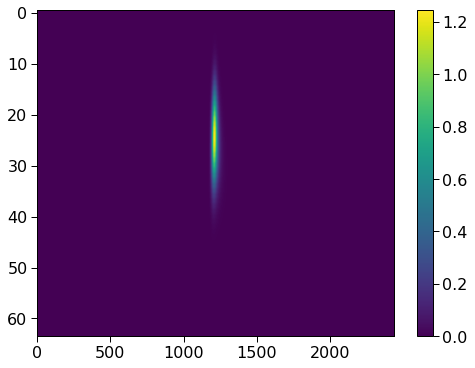

In [19]:
plot_me(bio.model)